In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

In [2]:
class Config:
    DATA_DIR='./data/'
    IMAGES_DIR=f'{DATA_DIR}images/'
    LABELS_DIR=f'{DATA_DIR}labels/'
    PATCH_SIZE=224
    PATCH_STEP=16
    NUM_CLASSES=7
    PALETTE = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
    TRAIN_RATIO = 0.7
    VAL_RATIO = 0.15
    TEST_RATIO = 0.15

#### Подготовка датасета

In [3]:
class LabelConverter:
    def __init__(self, palette):
        self.palette = palette
        self.revert_palette = {v: k for k, v in self.palette.items()}
    

    def convert_to_image(self, label):
        image = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)

        for klass, color in self.palette.items():
            m = label == klass
            image[m] = color

        return image

    def convert_to_label(self, image):
        image = image.transpose(1, 2, 0)
        label = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        for color, klass in self.revert_palette.items():
            m = np.all(image == np.array(color).reshape(1, 1, 3), axis=2)
            label[m] = klass

        return label

label_converter = LabelConverter(Config.PALETTE)

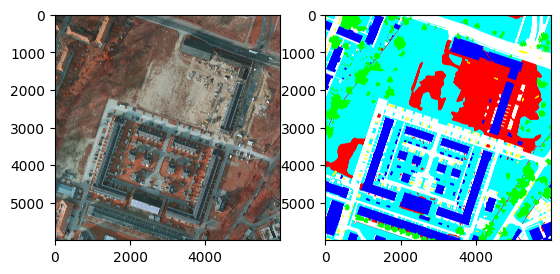

In [4]:
# We load one tile from the dataset and we display it
img = io.imread(f'{Config.IMAGES_DIR}top_potsdam_2_10_IRRG.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread(f'{Config.LABELS_DIR}top_potsdam_2_10_label.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

In [4]:
import torch
from torch.utils.data import Dataset
import os

class Patcher:
    def __init__(self, patch_size, step):
        self.patch_size = patch_size
        self.step = step


    def get_patches_data(self, image):
        image_size = image.shape
        data = []
        for x in range(0, image_size[1] - self.patch_size, self.step):
            for y in range(0, image_size[0] - self.patch_size, self.step):
                data.append((x, y))

        return data
    

    def get_patch(self, image, x_y):
        x, y = x_y
        return image[y:y + self.patch_size, x:x + self.patch_size, :]



class ISPRSDataset(Dataset):
    def __init__(self, patcher, label_converter, images_dir, labels_dir, cache=False):
        super(ISPRSDataset, self).__init__()
        
        self.patcher = patcher
        self.label_converter = label_converter

        self.cache = cache
        # self._image_patches_cache = []
        # self._label_patches_cache = []
        self._images_cache = []
        self._label_images_cache = []

        self.image_files = [os.path.join(images_dir, file) for file in os.listdir(images_dir) if file.endswith('.tif')]
        self.label_files = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir) if file.endswith('.tif')]
        

        assert len(self.image_files) == len(self.label_files), "Count of images and labels doesn't match!"

        self.patches_data = []
        self.indexes = []
        print("Start calculating meta-data...")
        for idx, image_file in enumerate(self.image_files):
            print(f"{idx}/{len(self.image_files)}")
            image = io.imread(image_file)
            if self.cache:
                label_image = io.imread(self.label_files[idx])
                self._images_cache.append(image)
                self._label_images_cache.append(label_image)
            data = self.patcher.get_patches_data(image)
            self.patches_data.extend(data)
            self.indexes.extend([idx] * len(data))

        print(f"Created dataset with {len(self.patches_data)} patches from {len(self.image_files)} images")

        # if self.cache:
        #     print("Start filling cache...")
        #     current_idx = None
        #     for idx in range(len(self)):
        #         if idx % 100 == 0:
        #             print(f"{idx}/{len(self)}")

        #         patch_data = self.patches_data[idx]
        #         if current_idx is None or current_idx != self.indexes[idx]:
        #             image_file = self.image_files[self.indexes[idx]]
        #             label_file = self.label_files[self.indexes[idx]]
        #             image = io.imread(image_file)
        #             label_image = io.imread(label_file)
        #             current_idx = self.indexes[idx]
        #         image_patch_tensor, label_patch_tensor = self._get_patches(image, label_image, patch_data)
        #         self._image_patches_cache.append(image_patch_tensor)
        #         self._label_patches_cache.append(label_patch_tensor)
        #     print("Done")

            
    def __len__(self):
        return len(self.patches_data)
    
    
    def __getitem__(self, idx):
        if self.cache:
            patch_data = self.patches_data[idx]
            image = self._images_cache[self.indexes[idx]]
            label_image = self._label_images_cache[self.indexes[idx]]

            return self._get_patches(image, label_image, patch_data)
        else:
            patch_data = self.patches_data[idx]
            image_file = self.image_files[self.indexes[idx]]
            label_file = self.label_files[self.indexes[idx]]

            image = io.imread(image_file)
            label_image = io.imread(label_file)

            return self._get_patches(image, label_image, patch_data)
    
    
    def _get_patches(self, image, label_image, patch_data):
        image_patch = np.asarray(self.patcher.get_patch(image, patch_data).transpose((2,0,1)), dtype='float16') / 255
        label_image_patch = np.asarray(self.patcher.get_patch(label_image, patch_data).transpose((2,0,1)), dtype='int8')
        label_patch = self.label_converter.convert_to_label(label_image_patch)

        return (
            torch.from_numpy(image_patch).float(),
            torch.from_numpy(label_patch).long()
        )

In [5]:
dataset = ISPRSDataset(
    Patcher(Config.PATCH_SIZE, Config.PATCH_STEP), 
    LabelConverter(Config.PALETTE), 
    Config.IMAGES_DIR,
    Config.LABELS_DIR, 
    cache=True)

Start calculating meta-data...
0/24
1/24
2/24
3/24
4/24
5/24
6/24
7/24
8/24
9/24
10/24
11/24
12/24
13/24
14/24
15/24
16/24
17/24
18/24
19/24
20/24
21/24
22/24
23/24
Created dataset with 3127704 patches from 24 images


#### Модель

In [6]:
import torch.nn as nn
from transformers import ViTModel

class ViTForSemanticSegmentation(nn.Module):
    def __init__(self, num_classes, img_size=Config.PATCH_SIZE, patch_size=16):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        
        # ViT энкодер
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.hidden_size = self.vit.config.hidden_size
        
        # Декодер (простой вариант)
        self.decoder = nn.Sequential(
            nn.Conv2d(self.hidden_size, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, num_classes, 1)
        )
        
    def forward(self, x):
        # ViT энкодер
        outputs = self.vit(x)
        last_hidden_state = outputs.last_hidden_state  # [batch, seq_len, hidden]
        
        # Извлекаем патч эмбеддинги (исключаем cls token)
        patch_embeddings = last_hidden_state[:, 1:]  # [batch, num_patches, hidden]
        
        # Решейп в 2D feature map
        batch_size = x.size(0)
        num_patches = patch_embeddings.size(1)
        grid_size = int(num_patches ** 0.5)  # предполагаем квадратное изображение
        
        features = patch_embeddings.permute(0, 2, 1).view(
            batch_size, self.hidden_size, grid_size, grid_size
        )
        
        # Декодер и интерполяция до исходного размера
        logits = self.decoder(features)
        logits = nn.functional.interpolate(
            logits, 
            size=self.img_size, 
            mode='bilinear', 
            align_corners=False
        )
        
        return logits

/home/quasar/Python/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Обучение

In [7]:
class Logger:
    pass #TODO Логирование метрик в файл, на сервер или в MLFlow и т.п.

In [8]:
from tqdm import tqdm

class ViTTrainer:
    def __init__(self, model, num_classes, opimizer, scheduler, train_loader, val_loader, device, logger):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=255)
        self.optimizer = opimizer
        self.scheduler = scheduler

        self.train_losses = []
        self.val_losses = []
        self.val_iou_scores = []
        
        self.logger = logger
        
    def train_epoch(self):
        """Одна эпоха обучения"""
        self.model.train()
        running_loss = 0.0
        
        pbar = tqdm(self.train_loader, desc="Training")
        for images, labels in pbar:
            # Перемещаем данные на устройство
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(images)
            
            # Вычисляем loss
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Обновляем статистику
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        epoch_loss = running_loss / len(self.train_loader)

        self.train_losses.append(epoch_loss)

        return epoch_loss
    
    def validate_epoch(self):
        """Валидация после эпохи"""
        self.model.eval()
        running_loss = 0.0
        total_iou = 0.0
        
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="Validation"):
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item()
                
                # Вычисляем IoU
                iou = self.calculate_iou(outputs, labels)
                total_iou += iou
        
        epoch_loss = running_loss / len(self.val_loader)
        epoch_iou = total_iou / len(self.val_loader)

        self.val_losses.append(epoch_loss)
        self.val_iou_scores.append(epoch_iou)

        return epoch_loss, epoch_iou
    
    def calculate_iou(self, outputs, labels):
        """Вычисляет Intersection over Union"""
        # Получаем предсказанные классы
        preds = torch.argmax(outputs, dim=1)
        
        ious = []
        for class_id in range(self.num_classes):
            pred_mask = (preds == class_id)
            true_mask = (labels == class_id)
            
            intersection = (pred_mask & true_mask).float().sum()
            union = (pred_mask | true_mask).float().sum()
            
            if union > 0:
                iou = intersection / union
                ious.append(iou.item())
        
        return np.mean(ious) if ious else 0.0
    
    def train(self, num_epochs, save_path='best_model.pth'):
        """Полный цикл обучения"""
        print(f"Starting training for {num_epochs} epochs on {self.device}")
        
        best_iou = 0.0
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            print("-" * 50)
            
            # Обучение
            train_loss = self.train_epoch()
            
            # Валидация
            val_loss, val_iou = self.validate_epoch()
            
            # Обновляем learning rate
            self.scheduler.step()
            
            # Выводим статистику
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | LR: {current_lr:.2e}")
            
            # TODO
            # self.logger.log({
            #     'train_loss': train_loss,
            #     'val_loss': val_loss,
            #     'val_iou': val_iou,
            #     'lr': current_lr
            # })
            
            # Сохраняем лучшую модель
            if val_iou > best_iou:
                best_iou = val_iou
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_iou': val_iou,
                    'val_loss': val_loss
                }, save_path)
                print(f"New best model saved with IoU: {val_iou:.4f}")
        
        print(f"\nTraining completed! Best IoU: {best_iou:.4f}")
        
    def plot_training_history(self):
        """Визуализация процесса обучения"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Val Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # IoU
        ax2.plot(self.val_iou_scores, label='Val IoU', color='green')
        ax2.set_title('Validation IoU')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('IoU')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

In [9]:
from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)
train_size = int(Config.TRAIN_RATIO * dataset_size)
val_size = int(Config.VAL_RATIO * dataset_size)
test_size = dataset_size - train_size - val_size

# Разделяем датасет
train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # для воспроизводимости
)

print(f"Train: {len(train_dataset)} samples")
print(f"Val: {len(val_dataset)} samples") 
print(f"Test: {len(test_dataset)} samples")

# Создаем DataLoader'ы
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Train: 2189392 samples
Val: 469155 samples
Test: 469157 samples


In [10]:
model = ViTForSemanticSegmentation(Config.NUM_CLASSES, Config.PATCH_SIZE, 16)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from torch import optim

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
device = torch.device('cpu') #По
logger = Logger()

trainer = ViTTrainer(
    model,
    Config.NUM_CLASSES,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    device,
    logger
)

In [12]:
trainer.train(5)

Starting training for 5 epochs on cpu

Epoch 1/5
--------------------------------------------------


Training:   0%|          | 130/218940 [20:52<585:46:35,  9.64s/it, Loss=0.0178]


KeyboardInterrupt: 